In [1]:
import pandas as pd
import numpy as np
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Q1:

In [4]:
def crr_binomial_option(S0, K, T, r, q, sigma, N, Option='C', Exercise='E'):
    
    # INput: Option = 'C' for calls; Excercise = 'E' for European, 'A' for American
    
    start_time = time.time()
    
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r-q) * dt) - d) / (u - d)
    
     # Generate price tree
    price_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            price_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
    
   # Generate option value tree
    option_tree = np.zeros_like(price_tree)
    
    # Terminal option value
    if Option == 'C':
        option_tree[:, -1] = np.maximum(0, price_tree[:, -1] - K)
    else:
        option_tree[:, -1] = np.maximum(0, K - price_tree[:, -1])
    
    # Backtrack option value
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_value = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            if Exercise == 'A':
                if Option == 'C':
                    option_value = max(option_value, price_tree[j, i] - K)
                else:
                    option_value = max(option_value, K - price_tree[j, i])
            option_tree[j, i] = option_value
            
    end_time = time.time()
    tol_time = end_time - start_time
    
    return [option_tree[0, 0],tol_time]

Q2:

In [3]:
def bsmprice(S,K,sigma,T,r,q, Option = 'C'):
    
    d1=(np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    if Option == 'C':
        bsprice = S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        bsprice = K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)

    return bsprice

In [4]:
S0 = 100  
K = 100   
T = 1     
r = 0.05  
q = 0.04
sigma = 0.2 

bsmp = bsmprice(S0,K,sigma,T,r,q, Option = 'C')
bsmp 

8.102643534463212

In [5]:
S0 = 100 
K = 100   
T = 1    
r = 0.05  
q = 0.04
sigma = 0.2  

european_call_price = pd.Series(dtype=float)
for N in range (1,1500):
    price_time = crr_binomial_option(S0, K, T, r, q, sigma, N, Option='C', Exercise='E')
    european_call_price.loc[N-1] = price_time[0] 
    if N % 100 == 0:
        print(N)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


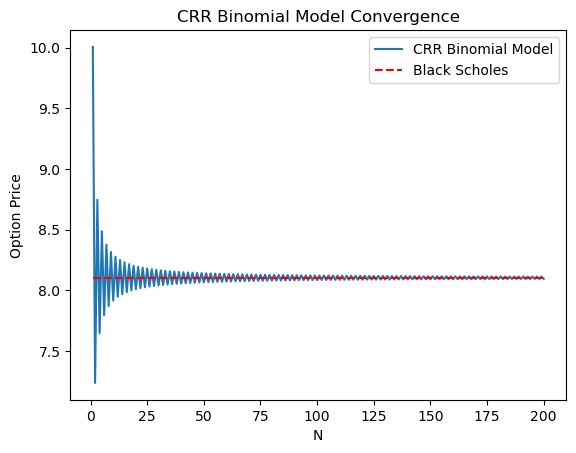

In [6]:
x = range(1, 201)
plt.plot(x,european_call_price[0:200],label = 'CRR Binomial Model')
plt.plot(x, [bsmp] * len(x), color='r', linestyle='--', label='Black Scholes')
plt.title('CRR Binomial Model Convergence')
plt.xlabel('N')
plt.ylabel('Option Price')
plt.legend()

# Display the plot
plt.show()

Q3:

In [7]:
def find_optimal_N_and_benchmark(S0, K, T, r, q, sigma, Option='P', Exercise='A', Visible = False):
    
    start_time = time.time()
    
   # Initial setup
    N = 10
    previous_price = None
    prices = []
    Ns = []
    
    # Loop until benchmark is found
    while True:
        current_price, _ = crr_binomial_option(S0, K, T, r, q, sigma, N, Option, Exercise)
        prices.append(current_price)
        Ns.append(N)
        
        if previous_price is not None:
            if abs(current_price - previous_price) < 1e-5:
                benchmark_price = current_price
                break
        
        previous_price = current_price
        N += 10 # Increase the time steps

    # Backtrack to find the first N that differs from the benchmark by less than 1e-3
    optimal_N = None
    for i in range(len(prices)):
        if abs(prices[i] - benchmark_price) < 1e-3:
            optimal_N = Ns[i]
            break
    
    # To ensure accuracy, gradually backtrack to find the earliest N that meets the error standard
    while optimal_N > 1:
        N = optimal_N - 1
        current_price, _ = crr_binomial_option(S0, K, T, r, q, sigma, N, Option, Exercise)
        if abs(current_price - benchmark_price) < 1e-3:
            optimal_N = N
        else:
            break
            
    # Visualize the loop process
    
    if Visible:
        print(prices)
    end_time = time.time()
    tol_time = end_time - start_time
    
    return optimal_N, benchmark_price, tol_time

In [8]:
# Call the function with specific parameters
optimal_N, benchmark_price, record_time = find_optimal_N_and_benchmark(
    S0=100,       # Initial stock price
    K=100,        # Strike price
    T=1,          # Time to maturity (in years)
    r=0.05,       # Risk-free interest rate
    q=0,          # Dividend yield
    sigma=0.2,    # Volatility
    Option='P',   # Option type ('P' for put, 'C' for call)
    Exercise='A', # Exercise type ('A' for American, 'E' for European)
    Visible=False # Whether to visualize the prices during the loop
)

# Print the results
print(f'Optimal N: {optimal_N}, Benchmark price: {benchmark_price}, Time: {record_time}')

Optimal N: 420, Benchmark price: 6.089488758361973, Time: 46.58896541595459


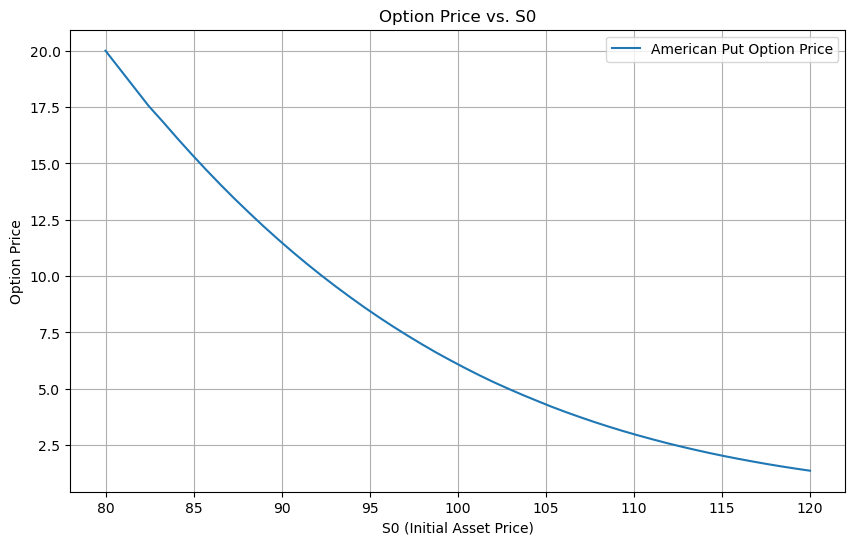

In [9]:
# Plot the S0 graph
K=100
T=1
r=0.05
q=0
sigma=0.2

# S0 range, from 80 to 120, with 50 evenly spaced points
S0_values = np.linspace(80, 120, 50)
option_prices = []

# Calculate the option price for each S
for S0 in S0_values:
    optimal_N, benchmark_price, _ = find_optimal_N_and_benchmark(S0, K, T, r, q, sigma)
    option_prices.append(benchmark_price)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(S0_values, option_prices, label='American Put Option Price')
plt.xlabel('S0 (Initial Asset Price)')
plt.ylabel('Option Price')
plt.title('Option Price vs. S0')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def find_early_exercise_boundary(K, T, r, q, sigma, N=500, Option='P', Visible=False):
    """
    Uses a binary search approach to find the early exercise boundary S* for American options, supporting both calls and puts.
    
    Parameters:
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free interest rate
    - q: Continuous dividend yield
    - sigma: Volatility of the underlying asset
    - N: Number of time steps (default 500)
    - Option: 'C' for call options, 'P' for put options
    - Visible: Print the found boundary value if True
    
    Returns:
    - S*: Estimated early exercise boundary value, rounded to two decimal places
    """
    
    # Initialize boundary
    if Option == 'P':
        low, high = 0, K  # Initial boundary for put options
    else:  # Option == 'C'
        low, high = K, 2 * K  # Initial boundary for call options
    
    epsilon = 0.005  # Error tolerance level
    precision = 0.01  # Output precision
    S_star = None

    while high - low > precision:
        mid = (low + high) / 2
        
        # Calculate option price and intrinsic value at the midpoint
        intrinsic_value = max(0, K - mid) if Option == 'P' else max(0, mid - K)
        option_price, _ = crr_binomial_option(mid, K, T, r, q, sigma, N, Option, Exercise='A')
        
        # Check if the boundary condition is satisfied
        if abs(option_price - intrinsic_value) < epsilon:
            S_star = mid
            # For put options, find a higher S*
            if Option == 'P':
                low = mid  # Try a higher S*
            # For call options, find a lower S*
            else:
                high = mid  # Try a lower S*
        else:
            # For put options, if condition not met, decrease S*
            if Option == 'P':
                high = mid  # S* should be lower
            # For call options, if condition not met, increase S*
            else:
                low = mid  # S* should be higher

    # Handle the found boundary
    if S_star is None:
        S_star = (low + high) / 2
    
    # Print the found boundary if Visible is True
    if Visible:
        print(f'S* for time {T*12}/12 is {S_star}')
        
    return round(S_star, 2)

# Example call
find_early_exercise_boundary(100, 1, 0.05, 0, 0.2, Visible=True)

S* for time 12/12 is 81.4208984375


81.42

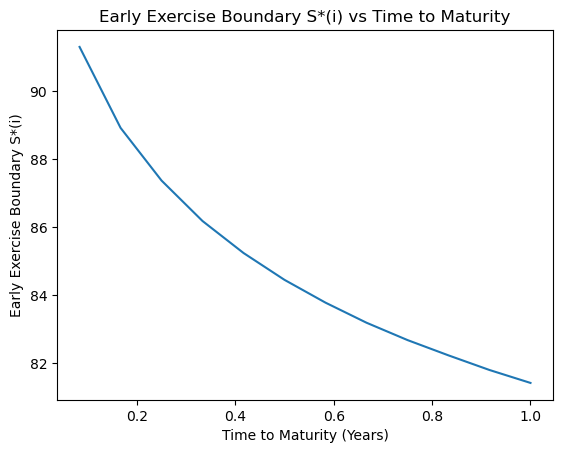

In [11]:
# Plotting：q=0，puts
S_star_values = []
for i in range(1,13):  # i from 1 to 12
    T = i / 12
    S_star = find_early_exercise_boundary(100, T, 0.05, 0, 0.2)
    S_star_values.append(S_star)

# Plot the curve of S*(i) changing with time
plt.plot([i/12 for i in range(1, 13)], S_star_values)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Early Exercise Boundary S*(i)")
plt.title("Early Exercise Boundary S*(i) vs Time to Maturity")
plt.show()

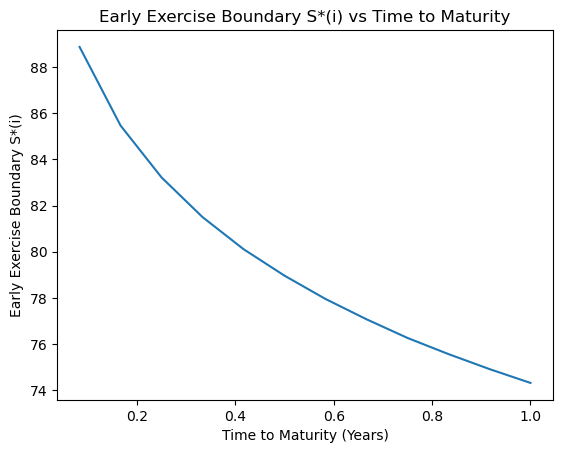

In [12]:
# Plotting: q=0.04, puts
S_star_values = []
for i in range(1, 13):  # i from 1 to 12
    T = i / 12
    S_star = find_early_exercise_boundary(100, T, 0.05, 0.04, 0.2)
    S_star_values.append(S_star)

# Plot the curve of S*(i) changing with time
plt.plot([i/12 for i in range(1, 13)], S_star_values)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Early Exercise Boundary S*(i)")
plt.title("Early Exercise Boundary S*(i) vs Time to Maturity")
plt.show()

Personal intuition: An increase in the dividend yield generally leads to a decrease in the early exercise boundary; this implies that with the same time to maturity, holders are more inclined to continue holding the option, making the 'time value' more valuable; due to the need to pay the dividend yield, the holder's psychological expectations increase.

Q4: Modify the input parameters from Q3 as needed.

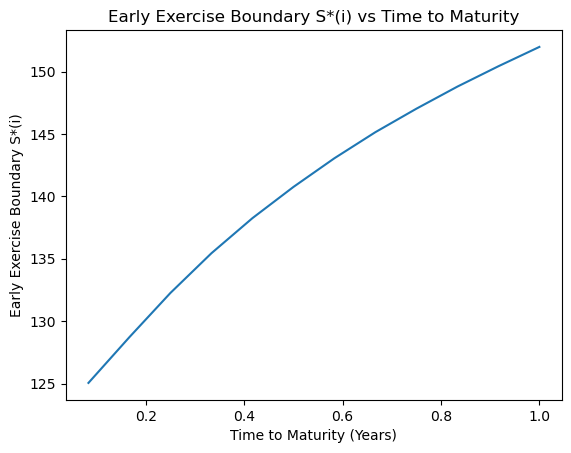

In [13]:
# Plotting: q=0.04, calls
S_star_values = []
for i in range(1, 13):  # i from 1 to 12
    T = i / 12
    S_star = find_early_exercise_boundary(100, T, 0.05, 0.04, 0.2, Option='C')
    S_star_values.append(S_star)

# Plot the curve of S*(i) changing with time
plt.plot([i/12 for i in range(1, 13)], S_star_values)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Early Exercise Boundary S*(i)")
plt.title("Early Exercise Boundary S*(i) vs Time to Maturity")
plt.show()

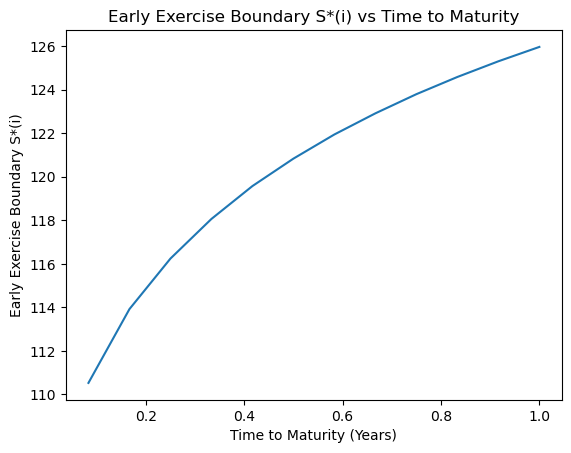

In [8]:
# Plotting: q=0.08, calls
S_star_values = []
for i in range(1, 13):  # i from 1 to 12
    T = i / 12
    S_star = find_early_exercise_boundary(100, T, 0.05, 0.08, 0.2, Option='C')
    S_star_values.append(S_star)

# Plot the curve of S*(i) changing with time
plt.plot([i/12 for i in range(1, 13)], S_star_values)
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Early Exercise Boundary S*(i)")
plt.title("Early Exercise Boundary S*(i) vs Time to Maturity")
plt.show()

Extra Credit 2:

First, let's review the content of the article (Burkovska et al. 2018. Page 3).

Left-side description and Algorithm 1 in the upper right corner:

Given 

​$S_0,r,T,\Delta t$, Find upper factor $u_i^*$ to let corresponding calculate price equals to market price.

Use Found $u_i^*$ to calculate European options price.

At last Calibration according to different models.

Here, we assume that the calculation of the option price is based on the binomial tree algorithm used earlier.

Next, let's review the problem requirements:

For the given data set (market prices of American options), implement the binomial de-Americanization approach described in Burkovska et al. 2018.

In this context, we are only required to obtain the de-Americanized pseudo-European option prices, without the need to calibrate parameters based on the model, so we do not consider the final calibration step in the original algorithm.

The problem is converted to estimating the factor 𝑢 based on the actual market option price, and then calculating the corresponding European option price and volatilities.

On the other hand, to our best knowledge, $u = \exp\{\sigma \sqrt{\Delta t}\}$.

So, in essence, it is about estimating σ based on the market price, i.e., the implied volatilities.

Approach: According to the crr_binomial_option function written in Q1, the parameter to be estimated is σ, and the method involves using the minimize function from the scipy.optimize package.

Objective function to minimize: $(market\_price-crr\_binomial\_option)^2$（Why?）

Think about this: The larger u, the larger p, which biases the option price higher, so the option price should be monotonic with respect to u.

In theory, there exists a unique u such that $market\_price-crr\_binomial\_option=0$, so it is reasonable to use the square of the difference as the optimization objective.



Below is an implementation of the code using a set of example parameters.

In [5]:
# Review of the binomial tree function

'''def crr_binomial_option(S0, K, T, r, q, sigma, N, Option='C', Exercise='E'):
    
    # INput: Option = 'C' for calls; Excercise = 'E' for European, 'A' for American
    
    start_time = time.time()
    
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r-q) * dt) - d) / (u - d)
    
    # Generate price tree
    price_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            price_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
    
    # Generate option value tree
    option_tree = np.zeros_like(price_tree)
    
    # Terminal option value
    if Option == 'C':
        option_tree[:, -1] = np.maximum(0, price_tree[:, -1] - K)
    else:
        option_tree[:, -1] = np.maximum(0, K - price_tree[:, -1])
    
  # Backtrack option value
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_value = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            if Exercise == 'A':
                if Option == 'C':
                    option_value = max(option_value, price_tree[j, i] - K)
                else:
                    option_value = max(option_value, K - price_tree[j, i])
            option_tree[j, i] = option_value
            
    end_time = time.time()
    tol_time = end_time - start_time
    
    return [option_tree[0, 0],tol_time]'''

# Define the objective function for optimization
def objective_function(sigma, S0, K, T, r, q, N, Option, Exercise, market_price):
    model_price,_ = crr_binomial_option(S0, K, T, r, q, sigma, N, Option, Exercise)
    return (model_price - market_price)**2

# Initialize parameters
S0 = 100
K = 100
T = 1
r = 0.05
q = 0.04
N = 500 
Option = 'C'
Exercise = 'A'
market_price = 8.0 # Example

initial_sigma = 0.2 # Initial guess

result = minimize(objective_function, initial_sigma, args=(S0, K, T, r, q, N, Option, Exercise, market_price), bounds=[(0.01, 2.0)])

# Output the estimated sigma
estimated_sigma = result.x[0]
print(f"Estimated sigma: {estimated_sigma:.4f}")
# The estimated sigma is the implied volatility

Estimated sigma: 0.1970


In [7]:
European_option_price,_ = crr_binomial_option(S0, K, T, r, q, estimated_sigma, N, Option, Exercise='E')
print(f"de-Americanized European option prices: {European_option_price:.4f}")

de-Americanized European option prices: 7.9852
